In [1]:
import cv2
from google.colab import files
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
model = load_model('/content/drive/MyDrive/Acne Detection Model/Demo/model_mobilenetv2_V1.h5')

Detect Only Single Acne

In [ ]:
base_dir = '/content/drive/MyDrive/Acne Detection Model/merged_dataset'
train_data_dir = os.path.join(base_dir, 'train', 'dataset')
val_data_dir = os.path.join(base_dir, 'valid', 'dataset')
test_data_dir = os.path.join(base_dir, 'test', 'dataset')
annotations_train_file = os.path.join(base_dir, 'train', '_annotations.csv')
annotations_val_file = os.path.join(base_dir, 'valid', '_annotations.csv')
annotations_test_file = os.path.join(base_dir, 'test', '_annotations.csv')

annotations_train = pd.read_csv(annotations_train_file)
annotations_val = pd.read_csv(annotations_val_file)

# Create image data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load and preprocess the training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=annotations_train,
    directory=train_data_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load and preprocess the validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=annotations_val,
    directory=val_data_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Define a function to perform acne detection and annotation
def detect_acne(image_path, model, threshold):
    # Read the input image using OpenCV
    image = cv2.imread(image_path)

    # Resize the image to the required dimensions
    image = cv2.resize(image, (224, 224))

    # Preprocess the image for model prediction
    input_data = preprocess_input(np.expand_dims(image, axis=0))

    # Perform the prediction using the loaded model
    predictions = model.predict(input_data)

    # Extract the acne instances and their class labels
    detections = []
    acne_labels = train_generator.class_indices

    for i, prediction in enumerate(predictions[0]):
        if prediction > threshold:
            acne_class = list(acne_labels.keys())[list(acne_labels.values()).index(i)]
            confidence = float(prediction)

            detections.append({
                'class': acne_class,
                'confidence': confidence
            })

    # Check if acne is detected or not
    if len(detections) > 0:
        print("You has Acne.")
        for detection in detections:
            acne_class = detection['class']
            confidence = detection['confidence']
            print(f"Type of acne: {acne_class}, Confidence: {confidence:.3f}")
    else:
        print("Yey yo dont have acne, Congrats .")

# Allow the user to upload an image file
uploaded = files.upload()

# Get the path of the uploaded image
image_path = next(iter(uploaded.keys()))

# Set the threshold for acne detection (adjust as needed)
threshold = 0.8

# Perform acne detection and annotation
detect_acne(image_path, model, threshold)

Found 41040 validated image filenames belonging to 4 classes.
Found 2881 validated image filenames belonging to 4 classes.


Saving acne-on-face-1326434308-770x533-1-650x428.jpg to acne-on-face-1326434308-770x533-1-650x428 (3).jpg
1/1 [==============================] - 0s 23ms/step
You has Acne.
Type of acne: nodules, Confidence: 0.976


Saving acne-on-face-1326434308-770x533-1-650x428.jpg to acne-on-face-1326434308-770x533-1-650x428 (4).jpg
1/1 [==============================] - 0s 37ms/step


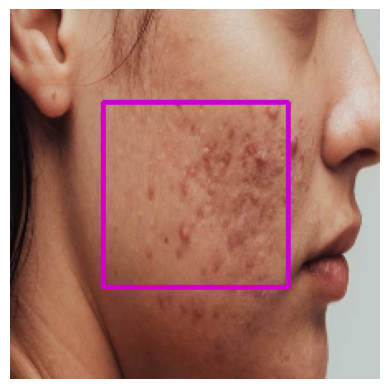

You have acne.
Type of acne: nodules, Confidence: 0.976


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_bounding_box(image, threshold):
    # Placeholder implementation
    # Replace this with your actual bounding box calculation logic
    height, width, _ = image.shape
    xmin = int(width * 0.25)
    ymin = int(height * 0.25)
    xmax = int(width * 0.75)
    ymax = int(height * 0.75)
    return xmin, ymin, xmax, ymax

def detect_acne(image_path, model, threshold):
    # Read the input image using OpenCV
    image = cv2.imread(image_path)

    # Resize the image to the required dimensions
    image = cv2.resize(image, (224, 224))

    # Preprocess the image for model prediction
    input_data = preprocess_input(np.expand_dims(image, axis=0))

    # Perform the prediction using the loaded model
    predictions = model.predict(input_data)

    # Extract the acne instances and their class labels
    detections = []
    acne_labels = {
        0: 'papules',
        1: 'nodules',
        2: 'pustules',
        3: 'comedones'
    }

    for i, prediction in enumerate(predictions[0]):
        if prediction > threshold:
            acne_class = acne_labels[i]
            confidence = float(prediction)

            detections.append({
                'class': acne_class,
                'confidence': confidence
            })

    # Draw bounding boxes on the image for detected acne instances
    if len(detections) > 0:
        for detection in detections:
            acne_class = detection['class']
            confidence = detection['confidence']

            # Get the predicted bounding box coordinates
            xmin, ymin, xmax, ymax = get_bounding_box(image, threshold)

            # Draw the bounding box on the image with purple-red color
            color = (203, 0, 203)  # Purple-red color (BGR format)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)

        # Display the output image with bounding boxes
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        print("You have acne.")
        for detection in detections:
            acne_class = detection['class']
            confidence = detection['confidence']
            print(f"Type of acne: {acne_class}, Confidence: {confidence:.3f}")
    else:
        print("You don't have acne. Congrats!")

# Allow the user to upload an image file
uploaded = files.upload()

# Get the path of the uploaded image
image_path = next(iter(uploaded.keys()))

# Set the threshold for acne detection (adjust as needed)
threshold = 0.5

# Perform acne detection and annotation
detect_acne(image_path, model, threshold)


Saving acne-on-face-1326434308-770x533-1-650x428.jpg to acne-on-face-1326434308-770x533-1-650x428.jpg
1/1 [==============================] - 8s 8s/step


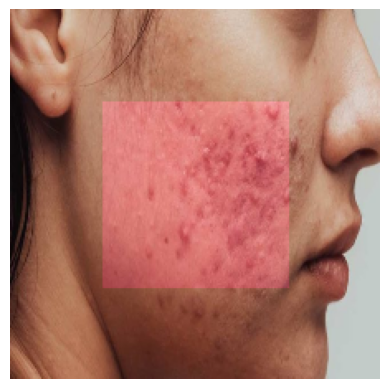

You have acne.
Type of acne: nodules, Confidence: 0.976


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_bounding_box(image, threshold):
    # Placeholder implementation
    # Replace this with your actual bounding box calculation logic
    height, width, _ = image.shape
    xmin = int(width * 0.25)
    ymin = int(height * 0.25)
    xmax = int(width * 0.75)
    ymax = int(height * 0.75)
    return xmin, ymin, xmax, ymax

def detect_acne(image_path, model, threshold):
    # Read the input image using OpenCV
    image = cv2.imread(image_path)

    # Resize the image to the required dimensions
    image = cv2.resize(image, (224, 224))

    # Preprocess the image for model prediction
    input_data = preprocess_input(np.expand_dims(image, axis=0))

    # Perform the prediction using the loaded model
    predictions = model.predict(input_data)

    # Extract the acne instances and their class labels
    detections = []
    acne_labels = {
        0: 'papules',
        1: 'nodules',
        2: 'pustules',
        3: 'comedones'
    }

    # Create a copy of the image to preserve the original
    image_with_boxes = image.copy()

    for i, prediction in enumerate(predictions[0]):
        if prediction > threshold:
            acne_class = acne_labels[i]
            confidence = float(prediction)

            detections.append({
                'class': acne_class,
                'confidence': confidence
            })

    # Draw bounding boxes on the image for detected acne instances
    if len(detections) > 0:
        for detection in detections:
            acne_class = detection['class']
            confidence = detection['confidence']

            # Get the predicted bounding box coordinates
            xmin, ymin, xmax, ymax = get_bounding_box(image, threshold)

            # Create a mask with the same shape as the image
            mask = np.zeros_like(image_with_boxes)

            # Draw a filled rectangle on the mask with the specified color
            color = (116, 0, 203)  # Pink color (BGR format)
            cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), color, cv2.FILLED)

            # Apply the mask to the image to make the area transparent
            image_with_boxes = cv2.addWeighted(image_with_boxes, 1, mask, 0.2, 0)

        # Display the output image with bounding boxes
        plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        print("You have acne.")
        for detection in detections:
            acne_class = detection['class']
            confidence = detection['confidence']
            print(f"Type of acne: {acne_class}, Confidence: {confidence:.3f}")
    else:
        print("You don't have acne. Congrats!")

# Allow the user to upload an image file
uploaded = files.upload()

# Get the path of the uploaded image
image_path = next(iter(uploaded.keys()))

# Set the threshold for acne detection (adjust as needed)
threshold = 0.5

# Perform acne detection and annotation
detect_acne(image_path, model, threshold)
